## Environment Setup

In [19]:
# Install required packages
%pip install --upgrade --no-cache-dir --force-reinstall \
    boto3 \
    botocore \
    faiss-cpu \
    ipython \
    langchain \
    langchain-community \
    langgraph \
    pandas \
    pydantic \
    pyowm \
    tavily-python \
    python-dotenv


# !pip install boto3 pandas faiss-cpu langchain langgraph openai python-dotenv mistralai
# !apt-get update && apt-get install -y sqlite3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 192.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 246.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.1/604.1 kB 285.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 401.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 184.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 246.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 347.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 375.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 414.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 365.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 284.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 426.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.

In [25]:
from dotenv import load_dotenv
import os

load_dotenv()  # Auto-loads .env from current working dir

# testing key are present
print("Weather Key:", os.getenv("OPENWEATHERMAP_API_KEY")[:5] + "*****")
print("Tavily Key:", os.getenv("TAVILY_API_KEY")[:5] + "*****")

Weather Key: 71d35*****
Tavily Key: tvly-*****


## Setup and Requirements

In [26]:
# standard library imports
import json
import logging
import sys
import traceback
from datetime import datetime
from typing import List, Dict

# AWS and third party import 
import boto3
import pandas as pd 
import sqlite3
from IPython.display import Image, display
from pydantic import BaseModel, Field
from tavily import TavilyClient

# Langchain imports
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveJsonSplitter
from langchain_aws import BedrockEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.utilities import OpenWeatherMapAPIWrapper

# LangGraph imports
from langgraph.graph import StateGraph, END
# from langgraph.prebuilt import ToolInvocation
from langgraph.checkpoint.memory import MemorySaver

In [27]:
# Set up structured logging to track execution steps and debug info
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [28]:
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv("OPENWEATHERMAP_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
AWS_REGION = "us-east-1"
DEFAULT_MODEL = "mistral.mistral-large-2402-v1:0"
DEFAULT_EMBEDDINGS = "amazon.titan-embed-text-v2:0"

In [29]:
# initialize bedrock client 
bedrock_client = boto3.client(service_name = 'bedrock-runtime', region_name = AWS_REGION)

In [30]:
# Define the "shared state structure using Pydantic" for validation and defaults.
# This state is passed between agents to hold results like events, search, weather, etc
class State(BaseModel):
    city : str   
    messages : List[Dict] = Field(default_factory = list)   
    events_result: str = ""   
    search_result: str = ""   
    weather_info: Dict[str, str] = Field(default_factory=dict)   
    analysis_result : str = ""   
    restaurant_recommendations: str = ""   

print("Setup Complete")

Setup Complete


## Use Case Explanation




This system takes a city name as input and provides the following information:

1. **Events**: It searches a local database if not in db then does online sources searches for upcoming events in the city.
2. **Weather**: It fetches current weather information for the city.
3. **Activities**: Based on the events and weather, it suggests suitable activities.
4. **Outfit Recommendations**: Considering the weather, it provides clothing suggestions.
5. **Dining Options**: It recommends highly-rated restaurants in the city.

This information is particularly useful for travelers or locals planning their activities.

## Data Preparation and Database Initialization


- Let's load our event data from a JSON file and initialize our SQLite database:


In [33]:
# load the json file directly into the data base 
df = pd.read_json('data/eventsDB_data.json') 

# initialize the SQLite database with the dataframe
def initialize_database(db_path,df):
    conn = sqlite3.connect(db_path) 
    df.to_sql('local_events', conn, if_exists='replace', index=False) 
    conn.close() 
    print(f"Database initialized with {len(df)} events.") 

# initalize the database
db_path = 'local_info.db'
initialize_database(db_path,df)

Database initialized with 54 events.


### Text Generation Function

The function works as follows:
1. Sends a user message to the Mistral model via the Bedrock Converse API.
2. Invokes the appropriate tool and incorporates the results into the conversation.
3. Continues the conversation until a final response is generated.

In [35]:
def generate_text(bedrock_client, model_id, tool_config, input_text):
    # Start the process and print which model is being used
    print("\nGenerating text with model:", model_id)
    is_mistral_model = model_id.startswith("mistral.")

    # Start the conversation with the user message
    messages = [{
        "role": "user",
        "content": [{"text": input_text}]
    }]

    # Only set advanced inference settings if it's a Mistral model
    inference_config = {
        "temperature": 0.5,
        "topP": 0.9,
        "maxTokens": 8192
    } if is_mistral_model else {}

    # Set up everything to send to Bedrock
    kwargs = {
        "modelId": model_id,
        "messages": messages,
        "inferenceConfig": inference_config
    }

    # Add tool settings if any tools are configured
    if tool_config:
        kwargs["toolConfig"] = tool_config

    tool_result = None  # Placeholder to store tool result if used

    # Keep the loop going until model says it's done or stops
    while True:
        # Send the message and get model response
        response = bedrock_client.converse(**kwargs)
        output_message = response['output']['message']
        messages.append(output_message)  # Save the assistant's response

        # Check if the model wants to use a tool (like weather or event search)
        stop_reason = response.get('stopReason')

        if stop_reason == 'tool_use' and tool_config:
            # Extract tool name, input, and tool ID
            tool_use = output_message['content'][0]['toolUse']
            tool_use_id = tool_use['toolUseId']
            tool_name = tool_use['name']
            tool_input = tool_use['input'] # what should be sent to tool for answer?

            try:
                # Handle each tool based on its name and run the correct function
                if tool_name == 'get_upcoming_events':
                    tool_result = events_database_tool(tool_input['city'])
                    json_result = json.dumps({"events": tool_result})
                elif tool_name == 'get_city_weather':
                    tool_result = weather_tool(tool_input['city'])
                    json_result = json.dumps({"weather": tool_result})
                elif tool_name == 'search_and_summarize_events':
                    tool_result = search_tool(tool_input['city'])
                    json_result = json.dumps({"events": tool_result})
                else:
                    # If an unknown tool is requested, raise an error
                    raise ValueError(f"Unknown tool: {tool_name}")

                # Format the tool response to send back to the model
                tool_response = {
                    "toolUseId": tool_use_id,
                    "content": [{"json": json.loads(json_result)}]
                }

            except Exception as e:
                # If the tool function fails, show an error and return text instead
                print(f"Error using tool {tool_name}: {str(e)}")
                tool_response = {
                    "toolUseId": tool_use_id,
                    "content": [{"text": f"Error using {tool_name}: {str(e)}"}],
                    "status": "error"
                }
                tool_result = None  # Clear tool result on error

            # Feed the tool's response back into the model
            messages.append({
                "role": "user",
                "content": [{"toolResult": tool_response}]
            })

            # Update the messages so the model sees the full conversation
            kwargs["messages"] = messages
        else:
            # If no tool is needed, stop the loop
            break

    # Return the model's final output and the tool result if used
    return output_message, tool_result

### Restaurant Synthetic Data Preparation

For restaurant recommendations using RAG, we are generating synthetic restaurant data with Mistral through Amazon Bedrock. This method enables us to create a customized dataset tailored to our specific needs. The `generate_restaurants_dataset` function constructs a prompt that defines the structure and content of the restaurant data we want to generate, including fields such as name, address, ratings, and categories.

In [36]:
%%time
def generate_restaurants_dataset(num_entries=10, required_cities=["Tampa", "Philadelphia"], required_cities_percentage=60, excluded_cities=["New York", "Miami", "Seattle"]):

    # Prompt for generating the synthetic dataset
    prompt = f"""Generate a dataset of {num_entries} restaurant and bar businesses in JSON format. Each business entry should include the following fields:

    - name: The name of the restaurant or bar (string)
    - address: The street address of the business (string)
    - city: The city where the business is located (string)
    - state: The state abbreviation where the business is located (string)
    - postal_code: The postal code of the business location (string)
    - stars: The rating of the business, from 1 to 5 (float)
    - review_count: The number of reviews for the business (integer)
    - is_open: Whether the business is currently open (1) or closed (0) (integer)
    - attributes: A nested object containing various attributes of the business (object)
    - categories: A comma-separated list of categories for the business, limited to restaurant and bar-related categories (string)

    Ensure that the data is diverse, covering various types of restaurants and bars, cuisines, locations, and ratings. 
    The generated dataset should be limited to restaurant and bar-related businesses only. 

    Important location requirements:
    1. At least {required_cities_percentage}% of the entries must be located in the following cities: {', '.join(required_cities)}.
    2. Do not generate any entries for the following cities: {', '.join(excluded_cities)}.
    3. The remaining entries can be for any other cities in the United States.

    Output the result as a valid JSON array without any additional text or explanation."""

    #call the model : for this tool_config will be None 
    raw_output, _ = generate_text(bedrock_client, DEFAULT_MODEL, None, prompt)
    json_string = raw_output['content'][0]['text']
    #print(json_string)
    
    # Parse the generated JSON
    generated_data = json.loads(json_string)
    
    # Create a DataFrame 
    df = pd.DataFrame(generated_data)
    return df
    

# Initialize an empty DataFrame to store all records
all_restaurants_records_df = pd.DataFrame()

#initialise how many calles to be made to LLM
total_calls = 15
entries_per_call = 5

# Loop to generate data in batches
for i in range(total_calls):
    print(f"\n\nBatch {i+1} of {total_calls} invoked...")
    
    #call the data generation function 
    restaurant_df = generate_restaurants_dataset(num_entries=entries_per_call)
    
    if restaurant_df is not None:
        all_restaurants_records_df = pd.concat([all_restaurants_records_df, restaurant_df], ignore_index=True)
    else:
        print(f"Failed to prepare batch {i+1}. Exiting.")
        exit(1)

# Save the combined DataFrame to a JSON file
output_file = "./data/restaurant_data.json"
all_restaurants_records_df.to_json(output_file, orient="records", indent=2)

print(f"\nAll {len(all_restaurants_records_df)} records saved to {output_file}\n\n")
all_restaurants_records_df



Batch 1 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 2 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 3 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 4 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 5 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 6 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 7 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 8 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 9 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 10 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 11 of 15 invoked...

Generating text with model: mistral.mistral-large-2402-v1:0


Batch 12 of 15 invoked...

G

,name,address,city,state,postal_code,stars,review_count,is_open,attributes,categories
0,The Columbia Restaurant,2117 E 7th Ave,Tampa,FL,33605,4.5,3456,1,"{'outdoor_seating': True, 'takeout': True, 'de...","Cuban, Spanish, Seafood"
1,Monk's Cafe,264 S 16th St,Philadelphia,PA,19102,4.0,1875,1,"{'outdoor_seating': False, 'takeout': False, '...","Belgian, Beer Bar, Gastropubs"
2,Buddy's Pizza,17125 Conant St,Detroit,MI,48212,4.5,2341,1,"{'outdoor_seating': False, 'takeout': True, 'd...","Pizza, Italian"
3,The Varsity,61 North Ave NW,Atlanta,GA,30308,3.5,3215,1,"{'outdoor_seating': False, 'takeout': True, 'd...","American (Traditional), Fast Food, Burgers"
4,Hop Sing Laundromat,1029 Race St,Philadelphia,PA,19107,4.5,215,1,"{'outdoor_seating': False, 'takeout': False, '...",Cocktail Bars
...,...,...,...,...,...,...,...,...,...,...
70,Tampa Bay Brewing Company,1600 E 8th Ave,Tampa,FL,33605,4.5,450,1,"{'outdoor_seating': True, 'good_for_kids': Fal...","brewery,bar,restaurant"
71,Reading Terminal Market,51 N 12th St,Philadelphia,PA,19107,4.5,12000,1,"{'indoor_seating': True, 'good_for_kids': True...","market,food court,restaurant"
72,Pat's King of Steaks,1237 E Passyunk Ave,Philadelphia,PA,19147,4.0,5500,1,"{'takeout': True, 'good_for_kids': True, 'late...","cheesesteaks,sandwiches,fast food"
73,Ulele,1810 N Highland Ave,Tampa,FL,33602,4.5,2500,1,"{'reservations': True, 'waterfront': True, 'ou...","american,seafood,bar"


## RAG Restaurant Vector Database Creation 

In [37]:
def create_restaurant_vector_store(df):
    # Convert DataFrame to list of dictionaries
    print("Converting DataFrame to list of dictionaries...")
    data = df.to_dict('records')

    # Use RecursiveJsonSplitter to split documents
    print("Splitting documents...")
    json_splitter = RecursiveJsonSplitter(max_chunk_size=1000)

    split_texts = [] # List to store split texts for each document
    metadata_list = []  # List to store metadata for each document
    for item in data:
        # Split the document into chunks
        split_texts.extend(json_splitter.split_text(json_data=item, convert_lists=True))
        
        # Directly extract metadata from the dictionary. To be used by similarity_search with filter_criteria
        metadata = {
            "city": item.get('city', ''),
            "stars": item.get('stars', 0),
            "name": item.get('name', ''),
        }
        metadata_list.append(metadata)
    
    # Create documents from split texts and attach corresponding metadata
    split_documents = [Document(page_content=text, metadata=metadata) for text, metadata in zip(split_texts, metadata_list)]

    # Initialize Bedrock Embeddings
    print("Initializing embeddings...")
    bedrock_embeddings = BedrockEmbeddings(
        region_name=AWS_REGION,
        model_id=DEFAULT_EMBEDDINGS
    )

    # Create vector store db
    print("Creating vector store...")
    vectorstore = FAISS.from_documents(split_documents, bedrock_embeddings)
    num_documents = len(vectorstore.index_to_docstore_id)
    
    return vectorstore, num_documents


In [38]:
# pull the cities from restaurant_data
df = pd.read_json('./data/restaurant_data.json')
# Remove duplicates based on the 'name' column, keeping the first occurrence
df_cleaned = df.drop_duplicates(subset=['name'], keep='first')

# pass restaurant_data through the embeddings
restaurant_vectorstore, num_documents = create_restaurant_vector_store(df_cleaned)
print(f"Restaurant Vector Store created successfully. \nNumber of documents indexed: {num_documents}")

Converting DataFrame to list of dictionaries...
Splitting documents...
Initializing embeddings...
Creating vector store...
2025-04-18 14:10:39,453 - INFO - Loading faiss with AVX512 support.
2025-04-18 14:10:39,479 - INFO - Successfully loaded faiss with AVX512 support.
2025-04-18 14:10:39,485 - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.
Restaurant Vector Store created successfully. 
Number of documents indexed: 42


### Restaurant Recommendation Function

This function uses the RAG system to provide restaurant recommendations.

In [41]:
def query_restaurants_RAG(city, vectorstore):
    query = f"Find restaurants with 4 star rating or higher in {city} and describe their key features"
    print(f"\nPerforming Query: {query}")

    #define the filter based on city and star rating
    filter_criteria = {
        "stars":{"$gte":4},
        "city":city
    }
    #perform similarity search on FAISS vectorstore
    relavant_docs = vectorstore.similarity_search(query, k=5, filter_criteria= filter_criteria)

    #display the relevant documents 
    if relavant_docs:
        print(f"\n Top {len(relavant_docs)} relavant documents for high-rated restaurants in {city}:")
        #its a dict so ,itertate through relavant docs 
        for i , doc in enumerate(relavant_docs, 1):
            print(f"\n Document {i}:")
            print(doc.page_content)
        context = "\n\n".join([doc.page_content for doc in relavant_docs]) #join all docs together
    else:
        print(f"No high rated restaurants found in the vector store db for {city}")

    
    # Generate the prompt for Bedrock
    prompt = f"""Task: Provide information about highly-rated restaurants (4 stars and above) in {city}.

    Instructions:
    1. If the following context contains information about restaurants in {city}, describe the key features that contribute to their high ratings. Consider aspects such as cuisine type, ambiance, service, price range, and any standout characteristics.
    2. Only use the information provided in the context. If certain information is not available, state that it's not mentioned.
    3. If no information is provided in the context, respond with: "I'm sorry, but I couldn't find any information about highly-rated restaurants in {city}."
    4. Do not generate or invent any information about restaurants if none is provided in the context.

    Context:
    {context}

    Please provide your response based on these instructions:"""

    #generate text using the bedrock model
    output_message,_ = generate_text(bedrock_client, DEFAULT_MODEL, None, prompt)

    #extract the reponse 
    response_content = output_message.get('content',[{}])[0].get('text', f"I'm sorry, but I couldn't find any information about highly-rated restaurants in {city}.")

    print("\nGenerated response:")
    print(response_content)

    return response_content    

### Testing the Restaurant RAG System

In [42]:
city = "Tampa"
df_cleaned_count = df_cleaned[df_cleaned['city']==city].shape[0]
print(f"Number of records with {city} as the city in df_cleaned: {df_cleaned_count}")
query_restaurants_RAG(city, restaurant_vectorstore)

Number of records with Tampa as the city in df_cleaned: 10

Performing Query: Find restaurants with 4 star rating or higher in Tampa and describe their key features

 Top 5 relavant documents for high-rated restaurants in Tampa:

 Document 1:
{"name": "Tampa Bay Seafood House", "address": "123 Harbor Drive", "city": "Tampa", "state": "FL", "postal_code": 33602, "stars": 4.5, "review_count": 350, "is_open": 1, "attributes": {"has_tv": true, "outdoor_seating": true, "wifi": false}, "categories": "Seafood, Restaurant, Bar"}

 Document 2:
{"name": "Datz", "address": "2616 S MacDill Ave", "city": "Tampa", "state": "FL", "postal_code": 33629, "stars": 4.5, "review_count": 7082, "is_open": 1, "attributes": {"accepts_credit_cards": true, "good_for_kids": true, "alcohol": "full_bar"}, "categories": "American (New), Breakfast & Brunch, Gastropubs"}

 Document 3:
{"name": "The Columbia Restaurant", "address": "2117 E 7th Ave", "city": "Tampa", "state": "FL", "postal_code": 33605, "stars": 4.5, "r

"Based on the provided context, here are the key features of the highly-rated restaurants in Tampa:\n\n1. Tampa Bay Seafood House:\n   - Cuisine Type: Seafood, Restaurant, Bar\n   - Standout Features: Outdoor seating and TV available\n   - Price Range: Not mentioned\n   - Ambiance: Not explicitly mentioned, but the presence of a TV and outdoor seating suggests a casual, relaxed atmosphere\n   - Service: Not mentioned\n\n2. Datz:\n   - Cuisine Type: American (New), Breakfast & Brunch, Gastropubs\n   - Standout Features: Accepts credit cards, good for kids, and has a full bar\n   - Price Range: Not mentioned\n   - Ambiance: Not explicitly mentioned, but the fact that it's good for kids and has a full bar suggests a family-friendly yet lively atmosphere\n   - Service: Not mentioned\n\n3. The Columbia Restaurant:\n   - Cuisine Type: Spanish, Cuban, Restaurant\n   - Standout Features: Accepts reservations, offers outdoor seating, and valet parking\n   - Price Range: Not mentioned\n   - Ambi

## Tools defination

### Local Database Query Tool

In [43]:
def events_database_tool(city:str)->str:
    conn = sqlite3.connect(db_path)
    query = """
            SELECT event_name, event_date, description 
            FROM local_events
            WHERE city = ?
            ORDER BY event_date
            LIMIT 3            
    """
    df = pd.read_sql_query(query, conn, params=(city,))
    conn.close()
    print(df)
    if not df.empty: 
        events=df.apply(lambda row : f"{row['event_name']} on {row['event_date']}:{row['description']}", axis=1).tolist()
        return "\n".join(events) 
    else: 
        return f"No upcoming events found for the {city}."       
    

### Weather Tool

This function fetches current weather data for the specified city by calling the . It's used by the **Weather Agent** :

In [44]:
def weather_tool(city:str)->str:
    #initalize the wrapper
    weather= OpenWeatherMapAPIWrapper() 
    tool_result= weather.run(city)
    return tool_result     

### Online Search Tool

In [45]:
def search_tool(city:str)->str: 
    client = TavilyClient(api_key= os.environ['TAVILY_API_KEY']) 
    query = f"What are the upcoming events in the {city}?"
    response = client.search(query, query_depth = 'advanced') 
    result_content= "\n\n".join([result['content'] for result in response['results']]) 
    return result_content

## Multi-agent System Definitions

In the project multi-agent system is composed of several specialized nodes, each responsible for a specific task. These nodes are then organized into a workflow using LangGraph. Here's an overview of the key components:

### Agent Functions

1. **Events Database Agent (events_database_agent)**: Queries the local database for upcoming events in a specified city.
2. **Online Search Agent(search_agent)**: Performs an online search for events when local data is unavailable.
3. **Weather Agent(weather_agent)**: Fetches current weather information for the specified city.
4. **Restaurants Recommendation Agent(query_restaurants_agent)**: This agent uses our RAG system to provide restaurant recommendations.
5. **Analysis Agent(analysis_agent)**: Synthesizes event and weather information to provide recommendations.

### 1. Event Database Agent
- Pulls data out of sqlite database regarding events 

In [54]:
def events_database_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("events_database_agent function called")
    print("*" * 50)
    tool_config = {
        "tools": [
            {
                "toolSpec": {
                    "name": "get_upcoming_events",
                    "description": "Get upcoming events for a specific city from the local database",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "city": {
                                    "type": "string",
                                    "description": "The name of the city to look up events for"
                                }
                            },
                            "required": ["city"]
                        }
                    }
                }
            }
        ]
    }
    
    input_text = f"Get upcoming events for {state.city} from the local database"
    output_message, tool_result = generate_text(bedrock_client, DEFAULT_MODEL, tool_config, input_text)
    
    if tool_result:
        state.events_result = tool_result
    else:
        state.events_result = "No event information available in the local database."
    
    print(f"Events set to: {state.events_result}")
    return state

### 2. Search Agent

- When local event information is not available in the database, this agent performs an online search:


In [55]:
def search_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("search_agent function called")
    print("*" * 50)
    tool_config = {
        "tools": [
            {
                "toolSpec": {
                    "name": "search_and_summarize_events",
                    "description": "Search for and summarize upcoming events for a specific city",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "city": {
                                    "type": "string",
                                    "description": "The name of the city to look up events for"
                                }
                            },
                            "required": ["city"]
                        }
                    }
                }
            }
        ]
    }
    
    input_text = f"Search for and summarize upcoming events in {state.city}"
    output_message, tool_result = generate_text(bedrock_client, DEFAULT_MODEL, tool_config, input_text)
    
    if tool_result:
        state.search_result = tool_result
    else:
        state.search_result = "No event information available from online search."
    
    print(f"Search result set to: {state.search_result[:500]}...")  # Print first 500 characters
    return state


### 3. Weather Agent

In [56]:
def weather_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("weather_agent function called")
    print("*" * 50)
    tool_config = {
        "tools": [
            {
                "toolSpec": {
                    "name": "get_city_weather",
                    "description": "Get current weather information for a specific city",
                    "inputSchema": {
                        "json": {
                            "type": "object",
                            "properties": {
                                "city": {
                                    "type": "string",
                                    "description": "The name of the city to look up weather for"
                                }
                            },
                            "required": ["city"]
                        }
                    }
                }
            }
        ]
    }
    
    input_text = f"Get current weather for {state.city}"
    output_message, tool_result = generate_text(bedrock_client, DEFAULT_MODEL, tool_config, input_text)
    
    if tool_result:
        state.weather_info = {"city": state.city, "weather": tool_result}
    else:
        state.weather_info = {"city": state.city, "weather": "Weather information not available."}
    
    print(f"Weather info set to: {state.weather_info}")
    return state


### 4. Restaurant Recommendation Agent
- This agent uses  RAG system to provide restaurant recommendations:


In [57]:
def query_restaurants_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("query_restaurants_agent function called")
    print("*" * 50)
    state.restaurant_recommendations = query_restaurants_RAG(state.city, restaurant_vectorstore)
    print(f"Restaurant recommendations set for {state.city}")
    return state   

### 5. Analysis Agent

- This agent synthesizes all the gathered information to provide a comprehensive analysis:

In [58]:
def analysis_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("analysis_agent function called")
    print("*" * 50)
    input_text = f"""Analyze the following information about {state.city}:

Events from local database: {state.events_result}
Events from online search: {state.search_result}
Weather: {state.weather_info['weather']}
Restaurant Recommendations: {state.restaurant_recommendations}

Please provide:
1. A brief weather analysis
2. Suggested activities based on the weather and events (from both local and online sources)
3. Outfit recommendations considering the weather
4. A summary of recommended restaurants and dining options"""

    output_message, _ = generate_text(bedrock_client, DEFAULT_MODEL, None, input_text)

    if 'content' in output_message and len(output_message['content']) > 0:
        state.analysis_result = output_message['content'][0]['text']
    else:
        state.analysis_result = "Unable to generate analysis."

    state.messages.append({"role": "assistant", "content": [{"text": state.analysis_result}]})
    
    print(f"Analysis result: {state.analysis_result[:500]}...")  # Print first 500 characters
    return state

## LangGraph Workflow Construction

Now that we have defined our agents, let's construct the LangGraph workflow that will orchestrate their interactions. The `build_graph` function creates the workflow structure:

- 1. Adds nodes for each agent (eventsDB, search, weather, restaurant recommendations, and analysis).
- 2. Sets the entry point to the events_database_agent.
- 3. Adds a conditional edge from events_database_agent to either search_agent or weather_agent.
- 4. Connects the remaining nodes in sequence.
- 5. Builds the graph and compiles the workflow.
- 6. Visualize the graph.

In [65]:
# Define the graph
def build_graph():
    workflow = StateGraph(State)

    workflow.add_node("Events Database Agent", events_database_agent)
    workflow.add_node("Online Search Agent", search_agent)
    workflow.add_node("Weather Agent", weather_agent)
    workflow.add_node("Restaurants Recommendation Agent", query_restaurants_agent)
    workflow.add_node("Analysis Agent", analysis_agent)

    workflow.set_entry_point("Events Database Agent")

    # Add conditional edge
    def route_events(state):
        print(f"Routing events. Current state: {state}")
        print(f"Events content: '{state.events_result}'")
        if f"No upcoming events found for {state.city}" in state.events_result:
            print("No events found in local DB. Routing to Online Search Agent.")
            return "Online Search Agent"
        else:
            print("Events found in local DB. Routing to Weather Agent.")
            return "Weather Agent"

    workflow.add_conditional_edges(
        "Events Database Agent",
        route_events,
        {
            "Online Search Agent": "Online Search Agent",
            "Weather Agent": "Weather Agent"
        }
    )

    workflow.add_edge("Online Search Agent", "Weather Agent")
    workflow.add_edge("Weather Agent", "Restaurants Recommendation Agent")
    workflow.add_edge("Restaurants Recommendation Agent", "Analysis Agent")
    workflow.add_edge("Analysis Agent", END)
    
    # Initialize memory to persist state between graph runs
    checkpointer = MemorySaver()

    # Compile the workflow
    app = workflow.compile(checkpointer=checkpointer)
    print("Workflow compiled successfully")
        
    # Visualize the graph
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API
            )
        )
    )

    #return app and checkpointer
    return app, checkpointer

print("Graph construction function defined.")

Graph construction function defined.


## Main Execution

Finally, let's define main execution function that will run the entire workflow. The used function orchestrates the entire process:

- 1. Initializes the state with the specified city.
- 2. Streams the events through the workflow.
- 3. Retrieves and displays the final analysis and recommendations.


In [82]:
# Main execution
def main(city: str):
    try:
        print(f"Starting main execution for city: {city}")
        app, checkpointer = build_graph()
        print("Graph built successfully")
                
        initial_state = State(
            city=city,
            messages=[{"role": "user", "content": [{"text": f"What's happening in {city} and what should I wear?"}]}],
            events_result="",
            weather_info={},
            analysis_result="",
            search_result="",
            restaurant_recommendations=""
        )

        # Configuration for the stream and checkpointer
        config = {
            "recursion_limit": 150,
            "configurable": {
                "thread_id": "42"  # Using string as thread_id
            }
        }

        print("Starting to stream events")
        # Stream the events with the required configurable key
        events = app.stream(
            initial_state,
            config=config
        )

        for output in events:
            if "__end__" not in output:
                print(f"\nIntermediate output: {output}")

        # Access the final state from the checkpointer
        final_state_dict = checkpointer.get(config=config)
        # Save the final state globally for user-facing display
        globals()["user_facing_state"] = final_state_dict

        # Print the final response from the assistant
        if 'channel_values' in final_state_dict and 'messages' in final_state_dict['channel_values']:
            messages = final_state_dict['channel_values']['messages']
            if messages and isinstance(messages, list):
                final_message = messages[-1]
                if final_message.get("role") == "assistant":
                    print("\nFinal response from the assistant:")
                    print(json.dumps(final_message["content"], indent=2))
                else:
                    print("\nNo final response from the assistant found in the messages.")
            else:
                print("\nNo valid messages found in the final state.")
        else:
            print("\nNo messages found in the final state.")

        # Print the full final state from checkpointer
        print("\nFinal state from checkpointer:")
        print(json.dumps(final_state_dict, indent=2))
        
    except Exception as e:
        print(f"An error occurred in main execution: {str(e)}")
        print(traceback.format_exc())

print("Main execution function defined.")


Main execution function defined.


## Results and Analysis

#### Example 1: Tampa, Florida

Starting script execution for city: Tampa
Starting main execution for city: Tampa
Workflow compiled successfully


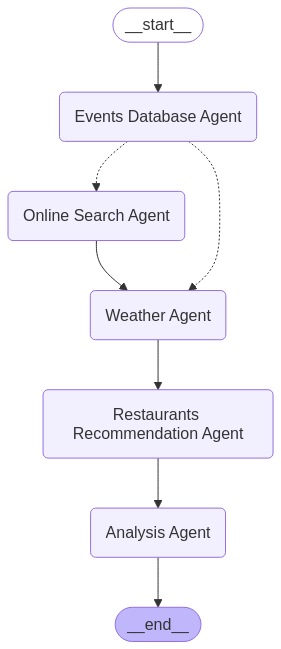

Graph built successfully
Starting to stream events

**************************************************
events_database_agent function called
**************************************************

Generating text with model: mistral.mistral-large-2402-v1:0
Empty DataFrame
Columns: [event_name, event_date, description]
Index: []
Events set to: No upcoming events found for the Tampa.
Routing events. Current state: city='Tampa' messages=[{'role': 'user', 'content': [{'text': "What's happening in Tampa and what should I wear?"}]}] events_result='No upcoming events found for the Tampa.' search_result='' weather_info={} analysis_result='' restaurant_recommendations=''
Events content: 'No upcoming events found for the Tampa.'
Events found in local DB. Routing to Weather Agent.

Intermediate output: {'Events Database Agent': {'city': 'Tampa', 'messages': [{'role': 'user', 'content': [{'text': "What's happening in Tampa and what should I wear?"}]}], 'events_result': 'No upcoming events found for th

In [83]:
if __name__ == "__main__":
    city = "Tampa"
    print(f"Starting script execution for city: {city}")
    main(city)

In [76]:
# Extract the final output safely from global variable
if "user_facing_state" in globals():
    raw_output = user_facing_state["channel_values"].get("analysis_result", "")

    # Pretty format it using our formatter
    pretty_output = format_analysis_output(raw_output)

    # Display to user
    print("👇 Here's your personalized day plan:")
    print(pretty_output)

else:
    print("⚠️ No analysis result found. Make sure you run main() first.")


### Example 2: Philadelphia, Pennsylvania

In [ ]:
if __name__ == "__main__":
    city = "Philadelphia"
    print(f"Starting script execution for city: {city}")
    main(city)

### Example 3: New York

In [ ]:
if __name__ == "__main__":
    city = "New York"
    print(f"Starting script execution for city: {city}")
    main(city)